In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.special import gamma
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def studentpdf(epsilon, nu):
    if nu <= 2: 
        return 0
    return gamma((nu + 1) / 2) / (gamma(nu / 2) * np.sqrt(np.pi * (nu - 2))) * (1 + epsilon ** 2 / (nu - 2)) ** (-(nu + 1) / 2)

def garch(mu, omega, alpha, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    sigma_squared[0] = omega / (1 - alpha - beta)
    for t in range(1, T):
        sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
    return sigma_squared

def negative_log_likelihood_garch(parameters, returns):
    mu, omega, alpha, beta, nu = parameters
    sigmasquared = garch(mu, omega, alpha, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigmasquared + 1e-8)
    ll = -np.log(np.sqrt(sigmasquared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

In [3]:
def asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns):
    T = len(returns)
    sigma_squared = np.zeros(T)
    initial_divisor = 1 - beta - alpha_pos / 2 - alpha_neg / 2
    if initial_divisor <= 0:
        initial_divisor = 1  # to prevent division by zero or negative values in the denominator
    sigma_squared[0] = omega / initial_divisor
    for t in range(1, T):
        epsilon_t = (returns[t-1] - mu) / np.sqrt(max(sigma_squared[t-1], 1e-8))  # Ensure denominator is not zero
        shock_effect = alpha_pos * (epsilon_t**2) if epsilon_t >= 0 else alpha_neg * (epsilon_t**2)
        sigma_squared[t] = omega + shock_effect + beta * sigma_squared[t-1]
    return sigma_squared

def neg_log_likelihood_asymmetric_garch(parameters, returns):
    mu, omega, alpha_pos, alpha_neg, beta, nu = parameters
    sigma_squared = asymmetric_garch(mu, omega, alpha_pos, alpha_neg, beta, returns)
    epsilon = (returns - mu) / np.sqrt(sigma_squared + 1e-8)
    ll = -np.log(np.sqrt(sigma_squared + 1e-8)) + np.log(studentpdf(epsilon, nu))
    return -np.sum(ll)

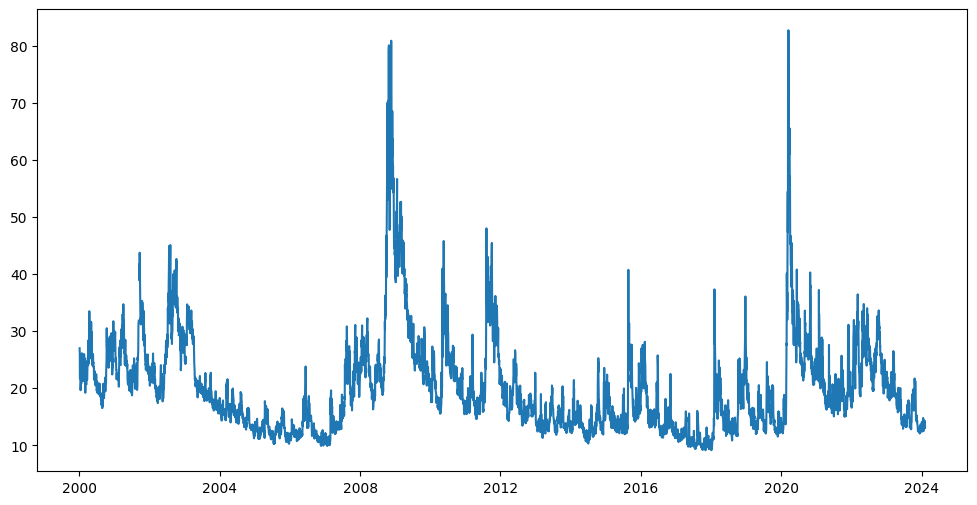

In [4]:
data = pd.read_excel('data.xlsx', index_col='date', parse_dates=True)
returns = data['close-to-close log  return'].values
dates = pd.to_datetime(data.index, format='%Y%m%d')

plt.figure(figsize=(12,6))
plt.plot(data['VIX close']);

/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_92738/615677109.py:17: RuntimeWarning: invalid value encountered in sqrt
  epsilon = (returns - mu) / np.sqrt(sigmasquared + 1e-8)
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_92738/615677109.py:18: RuntimeWarning: invalid value encountered in sqrt
  ll = -np.log(np.sqrt(sigmasquared + 1e-8)) + np.log(studentpdf(epsilon, nu))
/var/folders/4g/c51vpg2j0nj65hpt4ffnh7xm0000gn/T/ipykernel_92738/615677109.py:11: RuntimeWarning: overflow encountered in scalar multiply
  sigma_squared[t] = omega + alpha * (returns[t - 1] - mu) ** 2 + beta * sigma_squared[t - 1]
/Users/sanjayvonk/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


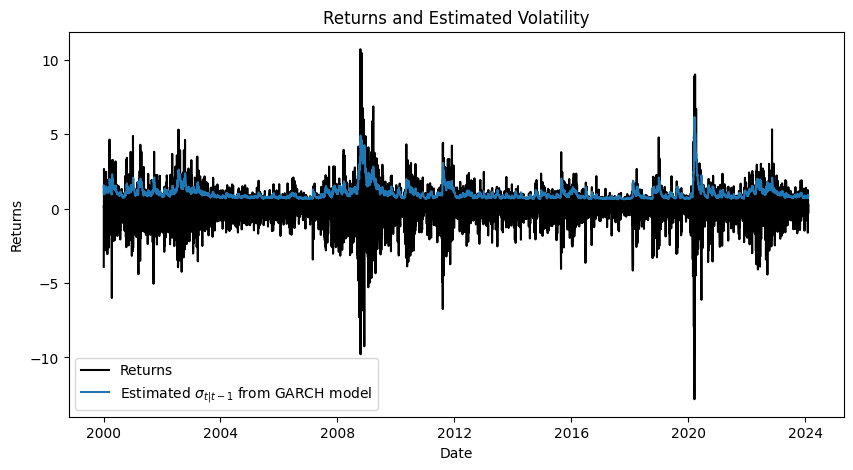

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8302.327754206302
        x: [ 7.452e-02  6.254e-02  1.012e-01  8.333e-01  5.999e+00]
      nit: 4
      jac: [ 3.692e+00  1.670e+03 -1.433e+03 -3.727e+02 -1.444e+00]
     nfev: 66
     njev: 11
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [5]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(negative_log_likelihood_garch, initial_values, args=(returns,), bounds=bounds)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat, beta_hat, nu_hat = result.x
sigmasquared = garch(mu_hat, omega_hat, alpha_hat, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\sigma_{t|t-1}$ from GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()
print(result)

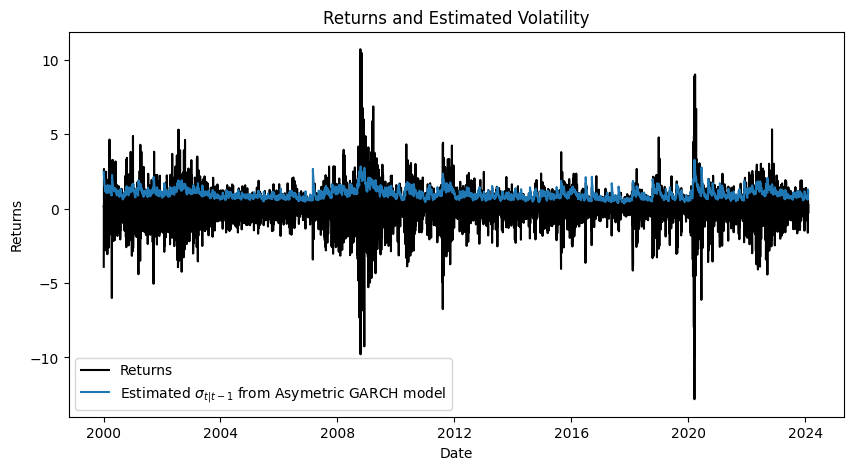

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8336.751357734425
        x: [ 4.716e-02  1.755e-04  7.213e-02  1.855e-01  8.711e-01
             5.999e+00]
      nit: 16
      jac: [-1.230e+02  2.007e+03  5.760e+03  4.998e+03  9.957e+03
            -1.547e+00]
     nfev: 371
     njev: 53
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


In [6]:
# Optimization setup
initial_values = [np.mean(returns), np.var(returns) / 20, 0.10, 0.1 , 0.88, 6]
bounds = [(None, None), (0, None), (0, None), (0, None), (0, None), (2, 40)]
result = optimize.minimize(neg_log_likelihood_asymmetric_garch, initial_values, args=(returns,), bounds=bounds)

# Extract optimized parameters
mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, nu_hat = result.x
sigmasquared = asymmetric_garch(mu_hat, omega_hat, alpha_hat_pos, alpha_hat_neg, beta_hat, returns)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates, returns, 'k', label='Returns')
plt.plot(dates, np.sqrt(sigmasquared), label='Estimated $\sigma_{t|t-1}$ from Asymetric GARCH model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Returns and Estimated Volatility')
plt.show()
print(result)